# Climatology generator demo sandbox

Date: 13 Novebmer, 2023

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is 16TB of data over nearly 9000 `netcdf` file assests in total.

#### required packages

In [1]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#more plotting
import matplotlib.dates as mdates
import seaborn as sns

#### start a local Dask client

In [2]:
from dask.distributed import Client
#client = Client(threads_per_worker=1)
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39195,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:44529,Total threads: 4
Dashboard: /proxy/42891/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:44209,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

# ARD workflow

### read paths from config file

#### [ you will need to specifiy your correct path for the `data-catalogue/config.ini` file ]

In [ ]:
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config file
#########
#### you will need to specifiy your correct path the the `data-catalogue/config.ini` file 
#########
config.read('./code/BRAN2020-intake-catalog/config.ini')

# Get the value of a variable
catalog_path = config.get('paths', 'catalog_path')

In [ ]:
catalog_path

In [ ]:
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json',columns_with_iterables=['variable'])

In [ ]:
BRAN2020_catalog

In [ ]:
BRAN2020_catalog.unique()['source']

In [ ]:
BRAN2020_catalog.unique()['domain']

In [ ]:
BRAN2020_catalog.unique()['time_period']

In [ ]:
var_list = BRAN2020_catalog.unique()['variable']
var_list.sort()
df = pd.DataFrame(var_list, columns=['BRAN2020 Variables'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

In [ ]:
search = BRAN2020_catalog.search(variable=['temp'],time_period='month')

In [ ]:
search.unique()['variable']

In [ ]:
search

In [ ]:
search.df

### Out of some 9000 files we now have narrowed down the just the 360 that have the information we need

### We can now load all that data into a single 396GB "lazy" `xarray` object for further reduction and analysis
#### Size is reduced from 16TB to 396GB

In [ ]:
%%time
DS = search.to_dask()

In [ ]:
DS

In [ ]:
DS.nbytes/1e9

## ARD - write zarr & chunk & write zarr

## 360 chunks is a bit too big for typical uses ( YMMV ) so rechunk depth by 10 = ~200MB

In [ ]:
DS_rc = DS.chunk({'st_ocean':10})
DS_rc

In [ ]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/'
ard_file_ID = 'BRAN2020-monthly-temp-v13112023b.zarr'

In [ ]:
%%time
DS_rc.to_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)
# ----- Client(threads_per_worker=1) -------
# CPU times: user 2min 26s, sys: 29.9 s, total: 2min 56s
# Wall time: 13min 1s
# ----- Client() -------
# CPU times: user 1min 53s, sys: 18.1 s, total: 2min 11s
# Wall time: 14min 3s

## RELOAD in ARD collection

In [ ]:
BRAN2020_monthly_temp = xr.open_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)
# size of collection is 169GB with compression

In [ ]:
BRAN2020_monthly_temp

## CHUNK for time and WRITE zarr

### "Consider either rechunking using `chunk()`, deleting or modifying `encoding['chunks']`"

In [ ]:
def remove_zarr_encoding(DS):
    for var in DS:
        DS[var].encoding = {}

    for coord in DS.coords:
        DS[coord].encoding = {}
    return DS

In [ ]:
ard_rcTime_file_ID = 'BRAN2020-monthly-temp-chunk4time-v13112023.zarr'

In [ ]:
BRAN2020_monthly_temp_rcTime =  BRAN2020_monthly_temp.chunk({'Time':-1,'st_ocean':1,'xt_ocean':100})

In [ ]:
BRAN2020_monthly_temp_rcTime = remove_zarr_encoding(BRAN2020_monthly_temp_rcTime)

In [ ]:
%%time
BRAN2020_monthly_temp_rcTime.to_zarr(BRAN2020_ard_path+ard_rcTime_file_ID,consolidated=True)
#  ----- Client() -------
# CPU times: user 2min 55s, sys: 24.4 s, total: 3min 20s
# Wall time: 14min 10s
#

## end ARD workflow $\Uparrow$

# begin post-processing workflow $\Downarrow$

## load in both zarr collections

In [4]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/'
ard_file_ID = 'BRAN2020-monthly-temp-v13112023.zarr'
ard_rcTime_file_ID = 'BRAN2020-monthly-temp-chunk4time-v13112023.zarr'

In [5]:
temp_chunked_time = xr.open_zarr(BRAN2020_ard_path + ard_rcTime_file_ID,consolidated=True)
temp_chunked = xr.open_zarr(BRAN2020_ard_path + ard_file_ID,consolidated=True)

## basic functions

In [6]:
def get_monthly_climatology(xr_object,time_coord_name = 'time',flox=True):
    if flox == True:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True,method="cohorts", engine="flox")
    else:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True)
    return monthly_climatology

def get_monthly_anomaly(xr_object,monthly_climatology, time_coord_name = 'time'):
    monthly_anomaly = xr_object.groupby(time_coord_name+'.month') - monthly_climatology
    return monthly_anomaly


# Climatology

In [7]:
temp_monthly_climatology = get_monthly_climatology(temp_chunked_time, time_coord_name = 'Time')
temp_monthly_climatology

<xarray.Dataset>
Dimensions:   (month: 12, st_ocean: 51, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    temp      (month, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 1, 1500, 100), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    grid_tile:                       N/A
    grid_type:                       regular
    intake_esm_attrs:_data_format_:  netcdf
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:time_period:    month
    intake_esm_attrs:variable:       temp
    intake_esm_dataset_key:          ocean.month
    intake_esm_vars:                 ['temp']
    title:                           BRAN2020

In [8]:
temp_monthly_climatology_rc = temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})

In [9]:
%%time
temp_monthly_climatology = temp_monthly_climatology.compute()

# CPU times: user 32.1 s, sys: 17.9 s, total: 49.9 s
# Wall time: 2min 20s
#

CPU times: user 29.5 s, sys: 18.4 s, total: 48 s
Wall time: 2min 18s


# Anomaly

In [10]:
temp_anomaly = get_monthly_anomaly(temp_chunked,temp_monthly_climatology_rc,time_coord_name='Time')

In [11]:
temp_anomaly

<xarray.Dataset>
Dimensions:   (Time: 360, st_ocean: 51, xt_ocean: 3600, yt_ocean: 1500)
Coordinates:
  * Time      (Time) datetime64[ns] 1993-01-16T12:00:00 ... 2022-12-16T12:00:00
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
    month     (Time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    temp      (Time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 10, 1500, 3600), meta=np.ndarray>

# define El Nino and La Nina using NCAR ONI data

In [12]:
ONI_DF = pd.read_csv('/g/data/xv83/users/tm4888/data/ENSO/NCAR_ONI.csv')
ONI_DF.set_index('datetime',inplace=True)
ONI_DF.index = pd.to_datetime(ONI_DF.index)
el_nino_threshold = 0.5
la_nina_threshold = -0.5
el_nino_threshold_months = ONI_DF["ONI"].ge(el_nino_threshold)
la_nina_threshold_months = ONI_DF["ONI"].le(la_nina_threshold) 
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.rename('El Nino threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.rename('La Nina threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.diff().ne(0).cumsum().rename('El Nino event group ID')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.diff().ne(0).cumsum().rename('La Nina event group ID')], axis=1)

In [13]:
El_Nino_Series = ONI_DF.groupby('El Nino event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['El Nino threshold'] == True)
ONI_DF = pd.concat([ONI_DF, El_Nino_Series.rename('El Nino')], axis=1)
La_Nina_Series = ONI_DF.groupby('La Nina event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['La Nina threshold'] == True)
ONI_DF = pd.concat([ONI_DF, La_Nina_Series.rename('La Nina')], axis=1)
ONI_DF

,year,month,ONI,El Nino threshold,La Nina threshold,El Nino event group ID,La Nina event group ID,El Nino,La Nina
datetime,,,,,,,,,
1950-01-15,1950,1,-1.53,False,True,1,1,NaN,NaN
1950-02-15,1950,2,-0.67,False,True,1,1,NaN,NaN
1950-03-15,1950,3,-0.43,False,False,1,2,NaN,NaN
1950-04-15,1950,4,-0.14,False,False,1,2,NaN,NaN
1950-05-15,1950,5,0.16,False,False,1,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-08-15,2023,8,1.32,True,False,58,52,NaN,NaN
2023-09-15,2023,9,1.54,True,False,58,52,NaN,NaN
2023-10-15,2023,10,NaN,False,False,59,52,NaN,NaN


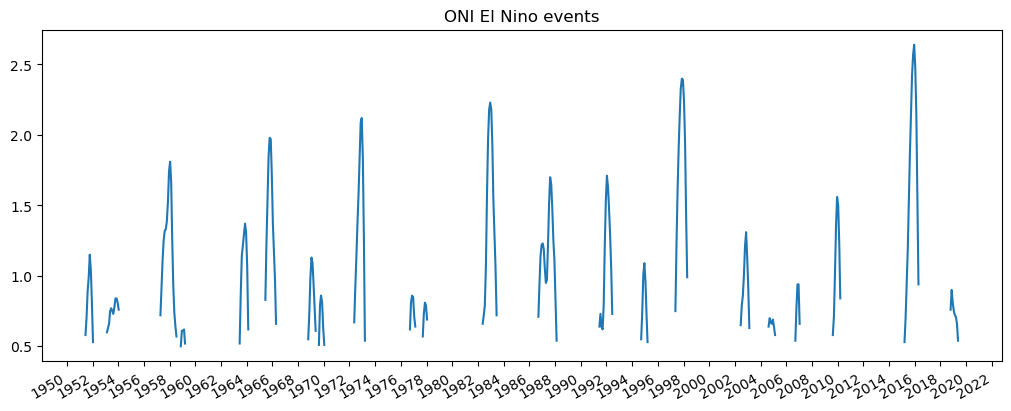

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['El Nino'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI El Nino events') 
plt.show()

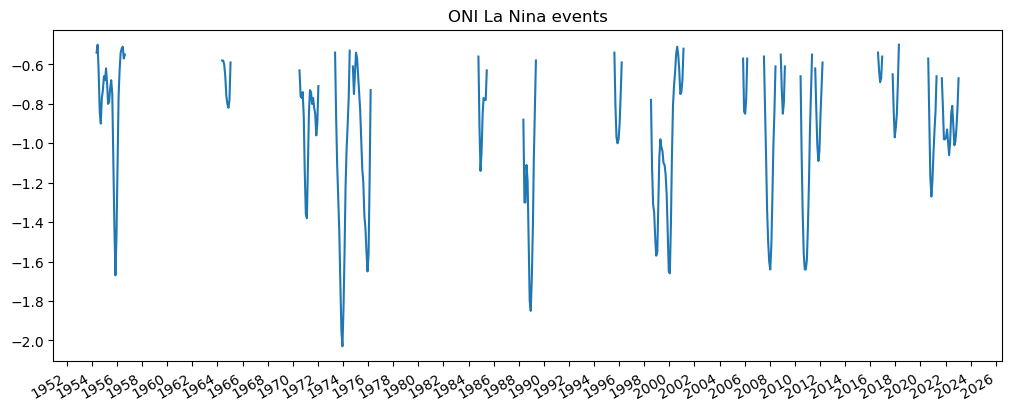

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['La Nina'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI La Nina events') 
plt.show()

## heatmap

### make table for average over certain region

In [16]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = temp_anomaly.temp.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'Time':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_of_ONI_anomaly = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_of_ONI_anomaly = spatial_mean_of_ONI_anomaly.compute()

CPU times: user 14.9 s, sys: 1.87 s, total: 16.8 s
Wall time: 55.2 s


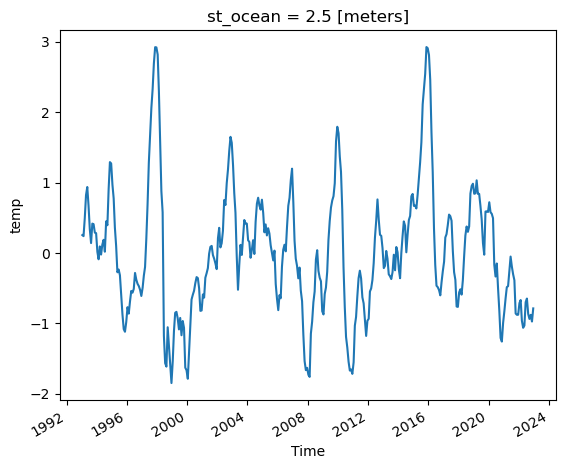

In [17]:
spatial_mean_of_ONI_anomaly.plot()

In [18]:
spatial_mean_of_ONI_anomaly_DF = spatial_mean_of_ONI_anomaly.to_dataframe()
spatial_mean_of_ONI_anomaly_DF['year'] = pd.DatetimeIndex(spatial_mean_of_ONI_anomaly_DF.index).year
spatial_mean_of_ONI_anomaly_DF

,st_ocean,month,temp,year
Time,,,,
1993-01-16 12:00:00,2.5,1,0.255235,1993
1993-02-15 00:00:00,2.5,2,0.239923,1993
1993-03-16 12:00:00,2.5,3,0.491316,1993
1993-04-16 00:00:00,2.5,4,0.822053,1993
1993-05-16 12:00:00,2.5,5,0.937453,1993
...,...,...,...,...
2022-08-16 12:00:00,2.5,8,-0.864896,2022
2022-09-16 00:00:00,2.5,9,-0.935764,2022
2022-10-16 12:00:00,2.5,10,-0.877171,2022


In [19]:
heatmap_data = spatial_mean_of_ONI_anomaly_DF.pivot_table(index='month', columns='year', values='temp')

In [20]:
heatmap_data

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
month,,,,,,,,,,,,,,,,,,,,,
1,0.255235,0.015690,0.968907,-0.768703,-0.492769,2.817869,-1.534865,-1.784969,-0.587681,0.212393,...,-0.213826,-0.234862,0.668597,2.811333,-0.122345,-0.558437,0.840971,0.721150,-0.822786,-0.711102
2,0.239923,-0.088524,0.776831,-0.860056,-0.321425,2.295861,-1.106866,-1.416627,-0.633088,0.358093,...,-0.180677,-0.357305,0.675072,2.460371,0.221036,-0.514353,0.847967,0.579761,-0.641563,-0.666962
3,0.491316,0.093737,0.360546,-0.688584,-0.197797,1.582830,-0.848049,-1.016395,-0.350456,0.079896,...,0.029498,-0.006372,0.632968,1.718212,0.268341,-0.589908,1.032360,0.557170,-0.484024,-0.960884
4,0.822053,-0.021300,0.099511,-0.538164,0.201133,0.879406,-0.835001,-0.660194,-0.287077,0.138389,...,-0.079857,0.237550,0.826899,1.149507,0.396249,-0.385830,0.839950,0.495377,-0.470431,-1.061166
5,0.937453,0.120176,-0.273497,-0.562905,0.691945,0.579174,-0.925447,-0.592766,-0.214206,0.314368,...,-0.301675,0.449518,1.060692,0.353956,0.545940,-0.052312,0.840057,-0.165420,-0.260115,-1.029243
6,0.673106,0.187943,-0.233838,-0.509503,1.284363,-1.175487,-1.083941,-0.535640,-0.009619,0.752423,...,-0.328717,0.386319,1.288176,-0.168270,0.524093,0.246985,0.671483,-0.333421,-0.050043,-0.697465
7,0.340081,0.018940,-0.314876,-0.282880,1.683615,-1.563643,-0.921439,-0.427022,0.087642,0.681835,...,-0.369237,0.010573,1.572489,-0.463709,0.458777,0.377046,0.476953,-0.148298,-0.192003,-0.646107
8,0.141533,0.450284,-0.595321,-0.378418,2.060111,-1.612657,-1.167103,-0.341701,0.101322,0.990818,...,-0.271504,0.263679,2.110776,-0.485323,0.026274,0.300992,0.140050,-0.504324,-0.302751,-0.864896
9,0.417649,0.394593,-0.870675,-0.436831,2.326096,-1.053800,-0.965122,-0.356017,-0.028959,1.186817,...,-0.024056,0.468885,2.329670,-0.525623,-0.272098,0.378010,-0.023382,-0.821247,-0.386113,-0.935764


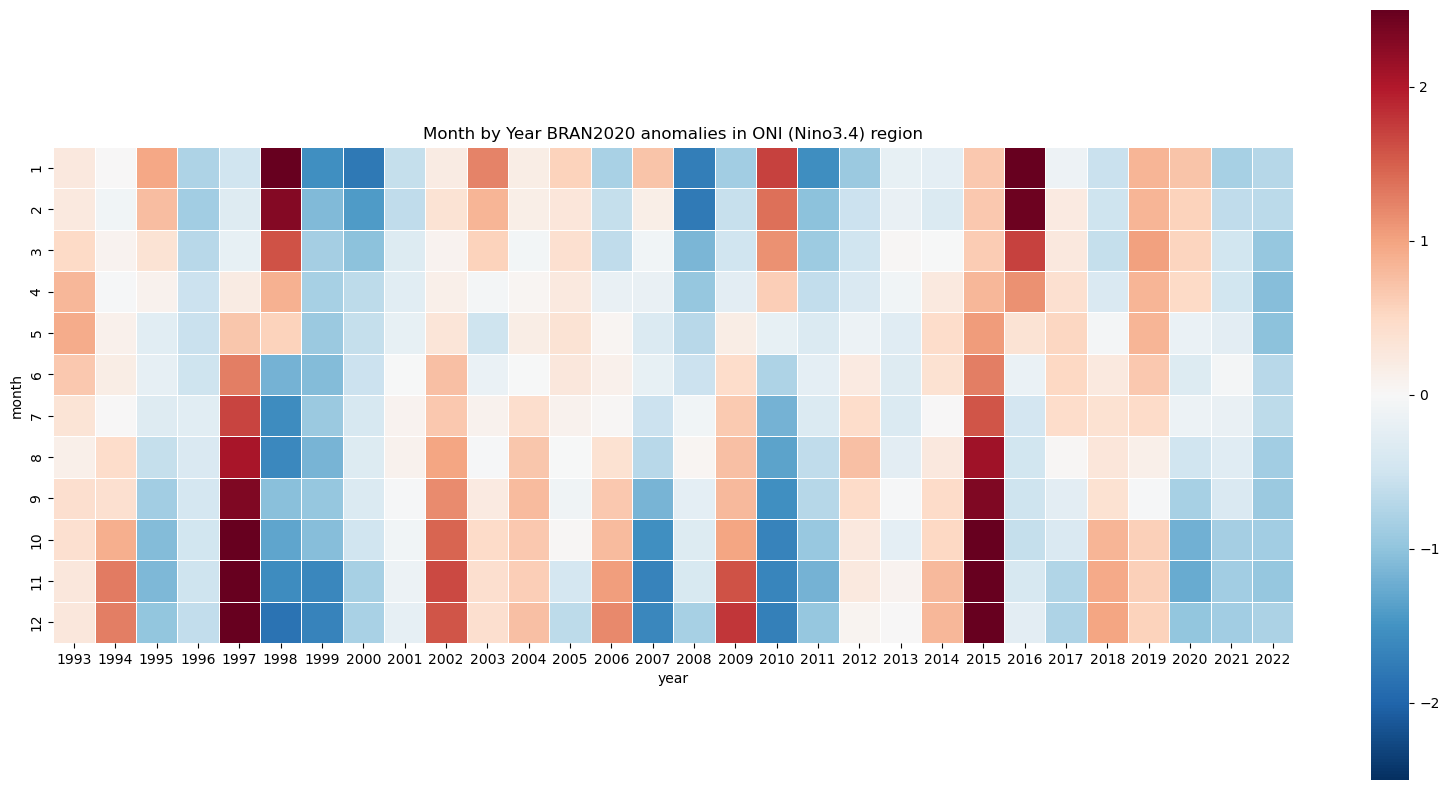

In [21]:
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region')
plt.show()

## stacked heatmap plot

In [22]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']

In [23]:
event_data_EN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='El Nino',dropna=False).fillna('')
event_data_LN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='La Nina',dropna=False).fillna('')

Text(0.5, 1.0, 'Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for defined ENSO events')

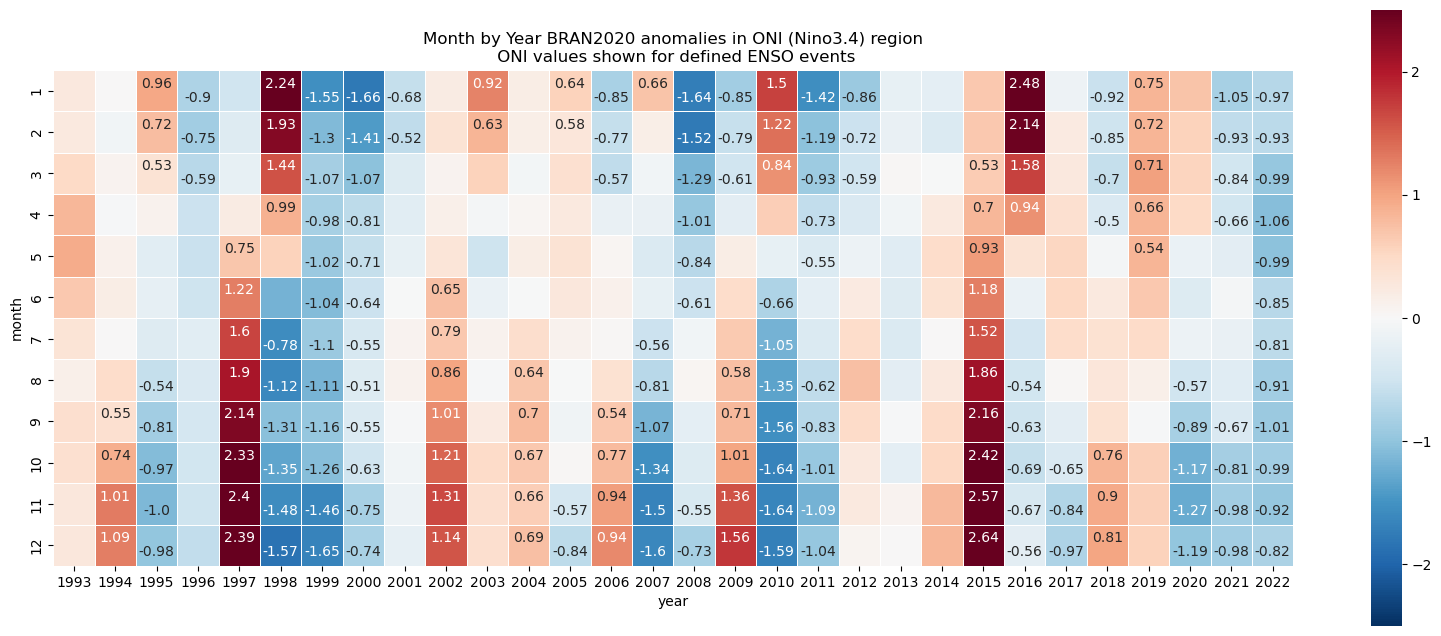

In [24]:
plt.figure(figsize=(20,8))
sns.heatmap(heatmap_data, annot=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_LN, annot_kws={'va':'top'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_EN, annot_kws={'va':'bottom'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for defined ENSO events')

#### count of events in BRAN2020 period
El Nino = 8 events ( weak - strong ) as defined by ONI<br>
La Nina = 10 events ( weak - strong ) as defined by ONI <br>
El Nino months total = 70 = 19%
La Nina months total = 119 = 33%
Neutral months total = 171 = 48%


In [39]:
ONI_DF_BRANtime 

,year,month,ONI,El Nino threshold,La Nina threshold,El Nino event group ID,La Nina event group ID,El Nino,La Nina,El Nino LOGICAL,La Nina LOGICAL
datetime,,,,,,,,,,,
1993-01-15,1993,1,0.09,False,False,35,28,NaN,NaN,False,False
1993-02-15,1993,2,0.30,False,False,35,28,NaN,NaN,False,False
1993-03-15,1993,3,0.50,True,False,36,28,NaN,NaN,False,False
1993-04-15,1993,4,0.67,True,False,36,28,NaN,NaN,False,False
1993-05-15,1993,5,0.70,True,False,36,28,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,2022,8,-0.91,False,True,57,51,NaN,-0.91,False,True
2022-09-15,2022,9,-1.01,False,True,57,51,NaN,-1.01,False,True
2022-10-15,2022,10,-0.99,False,True,57,51,NaN,-0.99,False,True


In [40]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum()

70

In [41]:
ONI_DF_BRANtime['La Nina LOGICAL'].sum()

119

In [45]:
ONI_DF_BRANtime['Neutral LOGICAL'].sum()

171

In [43]:
ONI_DF_BRANtime['Neutral LOGICAL'] = (ONI_DF_BRANtime['El Nino LOGICAL'] == False) & (ONI_DF_BRANtime['La Nina LOGICAL'] == False)

In [44]:
ONI_DF_BRANtime

,year,month,ONI,El Nino threshold,La Nina threshold,El Nino event group ID,La Nina event group ID,El Nino,La Nina,El Nino LOGICAL,La Nina LOGICAL,Neutral LOGICAL
datetime,,,,,,,,,,,,
1993-01-15,1993,1,0.09,False,False,35,28,NaN,NaN,False,False,True
1993-02-15,1993,2,0.30,False,False,35,28,NaN,NaN,False,False,True
1993-03-15,1993,3,0.50,True,False,36,28,NaN,NaN,False,False,True
1993-04-15,1993,4,0.67,True,False,36,28,NaN,NaN,False,False,True
1993-05-15,1993,5,0.70,True,False,36,28,NaN,NaN,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,2022,8,-0.91,False,True,57,51,NaN,-0.91,False,True,False
2022-09-15,2022,9,-1.01,False,True,57,51,NaN,-1.01,False,True,False
2022-10-15,2022,10,-0.99,False,True,57,51,NaN,-0.99,False,True,False


# filter BRAN2020 data by ENSO

In [25]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']
ONI_DF_BRANtime['El Nino LOGICAL'] = ONI_DF_BRANtime['El Nino'].notnull()
ONI_DF_BRANtime['La Nina LOGICAL'] = ONI_DF_BRANtime['La Nina'].notnull()
ONI_DF_BRANtime

,year,month,ONI,El Nino threshold,La Nina threshold,El Nino event group ID,La Nina event group ID,El Nino,La Nina,El Nino LOGICAL,La Nina LOGICAL
datetime,,,,,,,,,,,
1993-01-15,1993,1,0.09,False,False,35,28,NaN,NaN,False,False
1993-02-15,1993,2,0.30,False,False,35,28,NaN,NaN,False,False
1993-03-15,1993,3,0.50,True,False,36,28,NaN,NaN,False,False
1993-04-15,1993,4,0.67,True,False,36,28,NaN,NaN,False,False
1993-05-15,1993,5,0.70,True,False,36,28,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,2022,8,-0.91,False,True,57,51,NaN,-0.91,False,True
2022-09-15,2022,9,-1.01,False,True,57,51,NaN,-1.01,False,True
2022-10-15,2022,10,-0.99,False,True,57,51,NaN,-0.99,False,True


In [26]:
El_Nino_mask = ONI_DF_BRANtime['El Nino LOGICAL']
El_Nino_mask = El_Nino_mask.to_xarray()
El_Nino_mask = El_Nino_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
El_Nino_mask['Time'] = sync_Time

In [27]:
La_Nina_mask = ONI_DF_BRANtime['La Nina LOGICAL']
La_Nina_mask = La_Nina_mask.to_xarray()
La_Nina_mask = La_Nina_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
La_Nina_mask['Time'] = sync_Time

In [28]:
El_Nino_BRAN2020_temp = temp_chunked_time.temp.where(El_Nino_mask)
La_Nina_BRAN2020_temp = temp_chunked_time.temp.where(La_Nina_mask)

In [29]:
%%time
El_Nino_SST_mean = El_Nino_BRAN2020_temp.isel(st_ocean=0).mean('Time').compute()
La_Nina_SST_mean = La_Nina_BRAN2020_temp.isel(st_ocean=0).mean('Time').compute()

CPU times: user 1.25 s, sys: 195 ms, total: 1.45 s
Wall time: 5.22 s


Text(0.5, 1.0, 'Mean monthly BRAN2020 SST for El Nino - La Nina events')

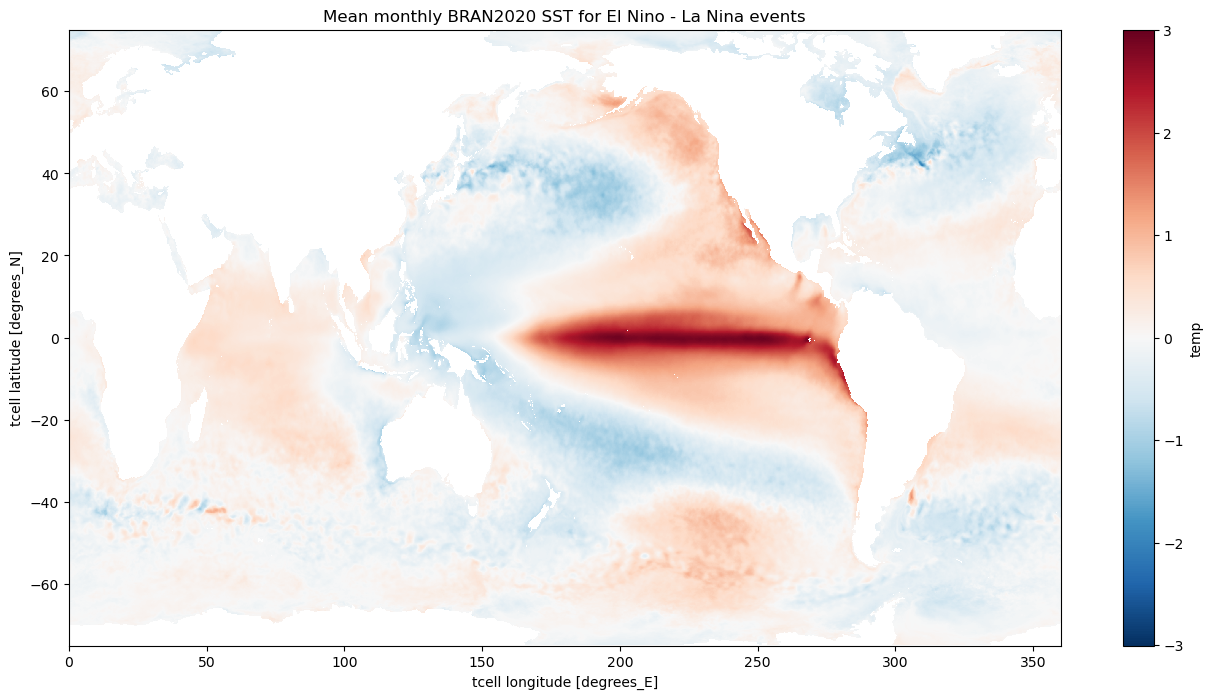

In [30]:
plt.figure(figsize=(16,8))
(El_Nino_SST_mean-La_Nina_SST_mean).plot()
plt.title('Mean monthly BRAN2020 SST for El Nino - La Nina events')

## El Nino "climatology"

In [31]:
%%time
El_Nino_temp_monthly_climatology = get_monthly_climatology(El_Nino_BRAN2020_temp, time_coord_name = 'Time')
El_Nino_temp_monthly_climatology_rc = El_Nino_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
El_Nino_temp_monthly_climatology = El_Nino_temp_monthly_climatology.compute()


CPU times: user 47.1 s, sys: 22.3 s, total: 1min 9s
Wall time: 3min 35s


## La Nina "climatology"

In [32]:
%%time
La_Nina_temp_monthly_climatology = get_monthly_climatology(La_Nina_BRAN2020_temp, time_coord_name = 'Time')
La_Nina_temp_monthly_climatology_rc = La_Nina_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
La_Nina_temp_monthly_climatology = La_Nina_temp_monthly_climatology.compute()

CPU times: user 2min 32s, sys: 1min 26s, total: 3min 59s
Wall time: 21min 22s


In [33]:
El_Nino_temp_monthly_climatology

<xarray.DataArray 'temp' (month: 12, st_ocean: 51, yt_ocean: 1500,
                          xt_ocean: 3600)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [ 0.18560785,  0.20961393,  0.23418438, ...,  0.13496049,
           0.15494956,  0.16900782],
         [ 0.65241545,  0.6926443 ,  0.73541516, ...,  0.5509018 ,
           0.58121514,  0.6152307 ],
         [ 1.4012351 ,  1.4394244 ,  1.478555  , ...,  1.2920961 ,
           1.3273666 ,  1.363579  ]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [-1.095286  , -1.0954115 , -1.0955371 , ..., -1.094031  ,
          -1.0943446 , -1.094784  ],
         [-1.096855  , -1.0966982 , -1.0971061 , ..., -1.0965726 ,
          -1.0970119 , -1.0969806 ],
         [-1.0970433 , -1.0968236 , -1.0972002 , ..., -1.0964785 ,
          -1.0967609 , -1.0971688 ]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    cell_methods:   time: mean Time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Potential temperature
    packing:        4
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degrees C
    valid_range:    [-32767, 32767]

In [34]:
diff_EN_LN_climatology = El_Nino_temp_monthly_climatology - La_Nina_temp_monthly_climatology

In [35]:
diff_EN_LN_climatology

<xarray.DataArray 'temp' (month: 12, st_ocean: 51, yt_ocean: 1500,
                          xt_ocean: 3600)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-2.64784664e-01, -2.43958190e-01, -2.07902193e-01, ...,
          -2.71917820e-01, -2.72513986e-01, -2.71739960e-01],
         [-1.67590201e-01, -1.58490479e-01, -1.52015507e-01, ...,
          -1.77160382e-01, -1.77035093e-01, -1.74253285e-01],
         [-1.24755263e-01, -1.22444153e-01, -1.22496724e-01, ...,
          -1.36303306e-01, -1.33019567e-01, -1.29525542e-01]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
          -1.12919807e-02, -1.12828016e-02, -1.14712715e-02],
         [-1.10857487e-02, -1.05882883e-02, -1.09064579e-02, ...,
          -1.15385056e-02, -1.19419098e-02, -1.14623308e-02],
         [-1.08436346e-02, -1.05521679e-02, -1.06419325e-02, ...,
          -1.10677481e-02, -1.09376907e-02, -1.08257532e-02]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [36]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = diff_EN_LN_climatology.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'month':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_diff_EN_LN = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_diff_EN_LN = spatial_mean_diff_EN_LN.compute()

CPU times: user 86.3 ms, sys: 36.3 ms, total: 123 ms
Wall time: 438 ms


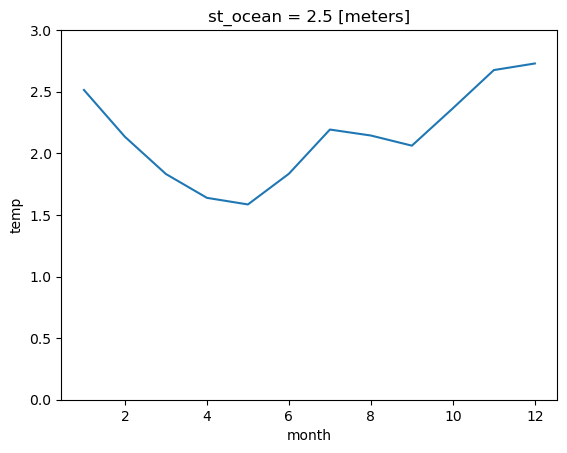

In [37]:
spatial_mean_diff_EN_LN.plot(ylim=[0,3])

CPU times: user 60.4 ms, sys: 4.59 ms, total: 65 ms
Wall time: 82.9 ms


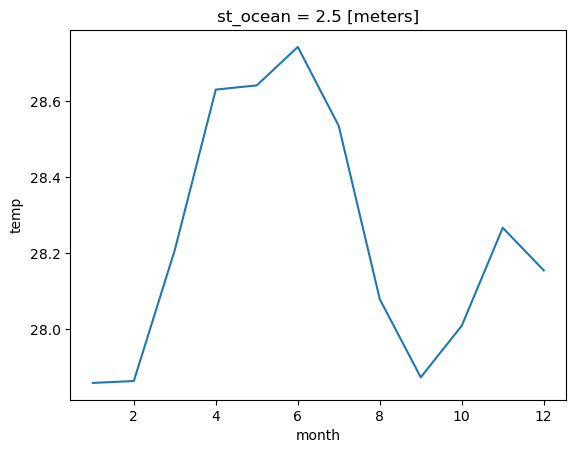

In [38]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = El_Nino_temp_monthly_climatology.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'month':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_EN = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_EN = spatial_mean_EN.compute()
spatial_mean_EN.plot()

# Mean, Median, Max , Min

In [58]:
El_Nino_mean = El_Nino_BRAN2020_temp.mean('Time')
El_Nino_median = El_Nino_BRAN2020_temp.median('Time')
El_Nino_max = El_Nino_BRAN2020_temp.max('Time')
El_Nino_min = El_Nino_BRAN2020_temp.min('Time')
El_Nino_std = El_Nino_BRAN2020_temp.std('Time')
El_Nino_quant = El_Nino_BRAN2020_temp.quantile([0.05,0.95],skipna=True,dim='Time')

In [ ]:
El_Nino_quant.isel(quantile=0).isel(st_ocean=0).plot()

In [ ]:
def get_slice(xr_object)
    max_lat = 5.0
    min_lat = -5.0
    max_lon = 240
    min_lon = 190
    LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
    SliceData = xr_object.sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})

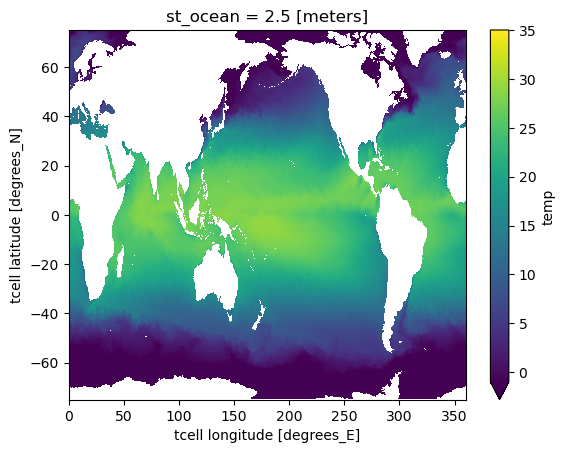

In [53]:
El_Nino_min.isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

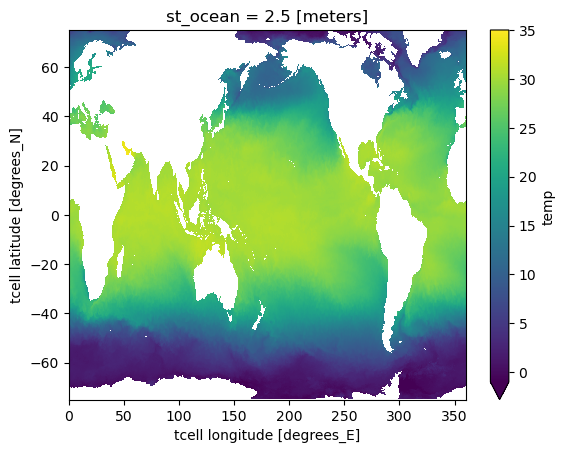

In [54]:
El_Nino_max.isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

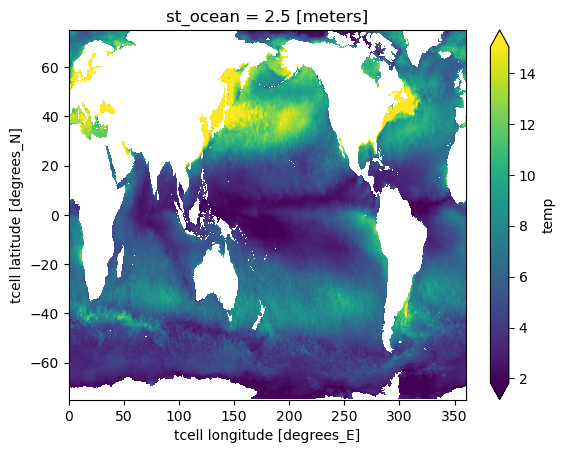

In [55]:
diff = El_Nino_max.isel(st_ocean=0) - El_Nino_min.isel(st_ocean=0) 
diff.plot(robust=True)

/g/data/v14/tm4888/miniconda3/envs/busecke_etal_grl_2019_omz_euc/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/v14/tm4888/miniconda3/envs/busecke_etal_grl_2019_omz_euc/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/v14/tm4888/miniconda3/envs/busecke_etal_grl_2019_omz_euc/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/v14/tm4888/miniconda3/envs/busecke_etal_grl_2019_omz_euc/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/v14/tm4888/miniconda3/envs/busecke_etal_grl_2019_omz_euc/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide

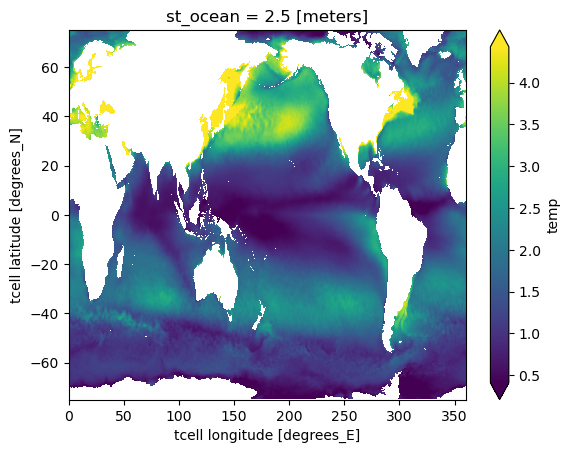

In [57]:
El_Nino_std.isel(st_ocean=0).plot(robust=True)

# The End

In [ ]:
client.shutdown()

## Plot current vectors for August

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline 

In [ ]:
%%time
# Define the u and v components of the currents
time_choice = 8
u = clim_uv.u.sel(month=time_choice)
v = clim_uv.v.sel(month=time_choice)
speed = np.sqrt(u**2 + v**2)

In [ ]:
#plot model data
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([142,160, -25, -10], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=2,alpha=0.2)
ax.set_title('BRAN2020 1993-2022\ncurrent speed \n August Climatology')